In [14]:
# make relevant imports
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# Plotting parameters
mpl.rc('text', usetex = True)
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [15]:
# Import data only for Italy

raw_data = pd.read_csv('owid-covid-data.csv', parse_dates=['date']).sort_index()
country = 'Italy'
data = raw_data[raw_data['location']==country]
data.set_index('date', inplace=True)

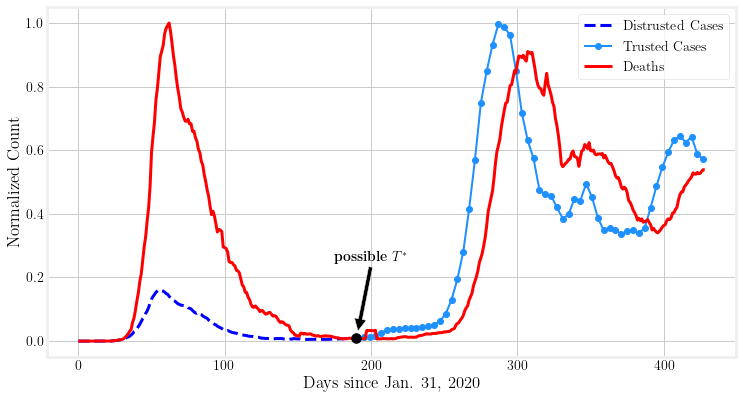

In [16]:
# Keep smoothed data

deaths = data['new_deaths_smoothed'].fillna(0).to_numpy()
cases = data['new_cases_smoothed'].fillna(0).to_numpy()


# Plot normalized cases Vs. normalized deaths

fig=plt.figure(figsize=(11, 6))
plt.scatter([190], [0.01], s=100, color='black', zorder=4)
plt.annotate(r'\textbf{possible} $T^*$', xytext=(175, 0.25), xy=(191,0.03),arrowprops = dict(facecolor ='black',
                                  shrink = 0.01))

fig.patch.set_facecolor('white')

nn_cases = cases/max(cases)

plt.plot(nn_cases[0:191],'b--', label='Distrusted Cases', linewidth=3, zorder=1)
plt.plot(np.arange(191,len(cases))[::4],nn_cases[191::4],'o-',c='dodgerblue', label='Trusted Cases', linewidth=2, zorder=2)
plt.plot(deaths/max(deaths),'r', label='Deaths', linewidth=3, zorder=3)
plt.xlabel('Days since Jan. 31, 2020')
plt.ylabel('Normalized Count')
#plt.title('Italy \n Normalized Cases and Deaths')
plt.legend();
#plt.savefig('Italy_case_death_comparison', bbox_inches='tight',pad_inches=0.1)
plt.show()


# Back-Casting Using GP

In [17]:
# keep smoothed data
deaths = data['new_deaths_smoothed'].fillna(0).to_numpy()
cases = data['new_cases_smoothed'].fillna(0).to_numpy()


# normalize to mean 0 variance 1.
deaths_n = (deaths - deaths.mean())/deaths.std()
cases_n = (cases - cases.mean())/cases.std()


################################################
# Create Tuples
################################################
time_window = 10 # set time window

case_targets = []
for i in range(time_window, len(cases)-1):
  case_targets.append(cases_n[i])


death_tuplets = []
death_targets = []
for i in range(0, len(deaths)-time_window-1):
  temp = []
  for j in range(time_window):
    temp.append(deaths_n[i+j])
  death_tuplets.append(temp)
  death_targets.append(deaths[i+j])
    
# convert to numpy
case_targets = np.array(case_targets)

death_tuplets = np.array(death_tuplets).squeeze()
death_targets = np.array(death_targets)

# Perform PCA on Deaths to Reduce # of dimensions

In [18]:
# make relevant imports
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

In [19]:
# define kernels

kernel1 = ConstantKernel() + Matern(length_scale=10, nu=7/2, length_scale_bounds=(10,30)) + WhiteKernel()
kernel2 = RBF(length_scale=50, length_scale_bounds=(10, 50)) + ConstantKernel() + WhiteKernel(noise_level_bounds=(0.01,0.03))

In [20]:
# perform regression

alpha=0.01 # error tolerance
gp_deaths_to_cases_1 = gaussian_process.GaussianProcessRegressor(kernel=kernel1)
gp_deaths_to_cases_2 = gaussian_process.GaussianProcessRegressor(kernel=kernel2, alpha=alpha)

gp_deaths_to_cases_1.fit(death_tuplets[:][160:], case_targets[160:]);
gp_deaths_to_cases_2.fit(death_tuplets[:][160:], case_targets[160:]);

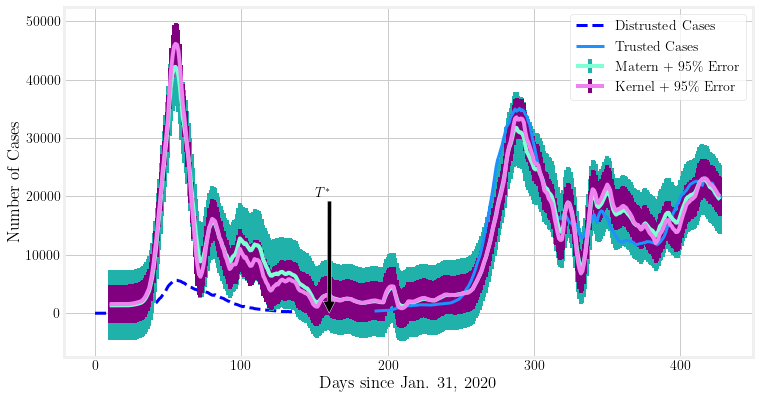

In [21]:
cases_pred_1, sigma_1 = gp_deaths_to_cases_1.predict(death_tuplets[:], return_std=True)
cases_pred_2, sigma_2 = gp_deaths_to_cases_2.predict(death_tuplets[:], return_std=True)

nn_cases_1 = cases_pred_1 * cases.std() + cases.mean()
nn_cases_2 = cases_pred_2 * cases.std() + cases.mean()

nn_sigma_1 = sigma_1 * cases.std()
nn_sigma_2 = sigma_2 * cases.std()

#plt.plot(np.arange(time_window, len(cases_pred_1)+time_window), nn_cases_1, label='Kernel 1 (Exponential)')
#plt.plot(np.arange(time_window, len(cases_pred_2)+time_window), nn_cases_2, label='kernel 2 (RBF)')

fig=plt.figure(figsize=(11,6))
fig.patch.set_facecolor('white')
plt.errorbar(np.arange(time_window,time_window+len(cases_pred_1),1), nn_cases_1, yerr=1.96*nn_sigma_1, color='aquamarine', ecolor='lightseagreen', mec='r',label='Matern + 95\% Error')
plt.errorbar(np.arange(time_window,time_window+len(cases_pred_1),1), nn_cases_2, yerr=1.96*nn_sigma_2, color='violet', ecolor='purple', mec='r',label='Kernel + 95\% Error')

plt.plot(cases[0:191],'b--', label='Distrusted Cases', linewidth=3, zorder=1)
plt.plot(np.arange(191,len(cases)),cases[191:],'-',c='dodgerblue', label='Trusted Cases', linewidth=3, zorder=2)

plt.scatter([160], [0.01], s=100, color='black')
plt.annotate(r'$T^*$', xytext=(150, 20000), xy=(160,0.03),arrowprops = dict(facecolor ='black',
                                  shrink = 1), zorder=4)

#plt.title('Back-Casting Result for Brazil \n time window: {} days'.format(time_window))
plt.ylabel('Number of Cases')
plt.xlabel('Days since Jan. 31, 2020')



# # x coordinates for the lines
# xcoords = [160]
# # colors for the lines
# colors = ['b']

# for xc,c in zip(xcoords,colors):
#     plt.axvline(x=xc, label=r'$T^*=160$',c='k')


plt.legend()
#plt.savefig('Italy_daily_backcasting', bbox_inches='tight',pad_inches=0.1);
plt.show()

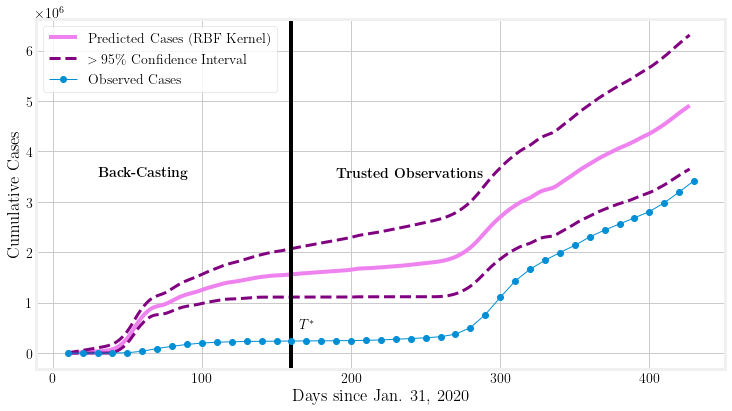

In [13]:
fig=plt.figure(figsize=(11,6))
fig.patch.set_facecolor('white')

#plt.plot(np.arange(time_window, len(nn_cases_1)+time_window), nn_cases_1.cumsum(),c='aquamarine')
#plt.plot(np.arange(time_window, len(nn_cases_1)+time_window), nn_cases_1.cumsum()+nn_sigma_1.cumsum(),'--', c='lightseagreen')
#plt.plot(np.arange(time_window, len(nn_cases_1)+time_window), nn_cases_1.cumsum()-nn_sigma_1.cumsum(),'--', c='lightseagreen')
plt.plot(np.arange(time_window, len(nn_cases_2)+time_window), nn_cases_2.cumsum(), c='violet', label='Predicted Cases (RBF Kernel)')
plt.plot(np.arange(time_window, len(nn_cases_2)+time_window), nn_cases_2.cumsum()+1.96*nn_sigma_2.cumsum(),'--', c='purple', linewidth=3, label=r'$>95\%$ Confidence Interval')
a = nn_cases_2-1.96*nn_sigma_2
a[a<0]=0
plt.plot(np.arange(time_window, len(nn_cases_2)+time_window), a.cumsum(),'--', c='purple', linewidth=3)

# x coordinates for the lines
xcoords = [160]
# colors for the lines
colors = ['b']

for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c='k')

plt.annotate(r'\textbf{Trusted Observations}', xytext=(190, 3500000), xy=(190, 200000))
plt.annotate(r'\textbf{Back-Casting}', xytext=(30, 3500000), xy=(190, 200000))
plt.annotate(r'$T^*$', xytext=(165, 500000), xy=(160, 0))

plt.plot(np.arange(time_window, len(nn_cases_2)+time_window+10)[::10],cases.cumsum()[::10],'o-', linewidth=1,label='Observed Cases')
plt.ylabel('Cumulative Cases')
plt.xlabel('Days since Jan. 31, 2020')
#plt.title('Cumulative Back-Casting for Brazil \n time window: 10 days')
plt.legend();
#plt.savefig('Italy_Back-Casting_Cumulative', bbox_inches='tight',pad_inches=0.1);
plt.show()